In [76]:
from libemg import streamers, data_handler, filtering, gui, emg_predictor, feature_extractor, utils
import os
import json
import time
from os import walk

import numpy as np
from libemg.offline_metrics import OfflineMetrics

import socket

from drive import accelerate , brake , steer_left , steer_right , reset_controls
import vgamepad as vg 


In [77]:
WINDOW_SIZE = 200 # 40
WINDOW_INC = 20
CLASSES = [0, 1, 2 , 3, 4]
REPS = [0, 1, 2, 3, 4 , 5]
STAGE = 4 # 0: collect data, 1: prepare model, 2: test band, 3: test model, 4: prepare emg model, 5: prepare emg imu ppg model


In [ ]:
def testband():
    streamer, smm = streamers.sifi_biopoint_streamer(name='BioPoint_v1_3',  ecg=True,  imu=True, ppg=True, eda=True, emg=True,filtering=True,emg_notch_freq=60)
    odh = data_handler.OnlineDataHandler(smm)
    #odh is your data
    odh.visualize(num_samples=10000)

In [ ]:
def get_training_data(folder_location, regex_filters):
    odh = data_handler.OfflineDataHandler()
    odh.get_data(folder_location=folder_location, regex_filters=regex_filters)
    windows, metadata = odh.parse_windows(WINDOW_SIZE,WINDOW_INC)
    fi_emg = filtering.Filter(2000)
    
    standardization_filter = { "name": "standardization"}
    emg_notch_filter = { "name": "notch", "cutoff": 60, "bandwidth": 3}
    emg_bandpass_filter = { "name":"bandpass", "cutoff": [20, 450], "order": 4}

    fi_emg.install_filters(standardization_filter)
    fi_emg.install_filters(emg_notch_filter)
    fi_emg.install_filters(emg_bandpass_filter)

    # 2. Filter the RAW DATA
    filtered_windows = fi_emg.filter(windows)  # <-- KEY FIX: Use filtered data
    
    # 3. Extract features from FILTERED DATA
    fe = feature_extractor.FeatureExtractor()
    feature_dic = {
        'training_features': fe.extract_feature_group("LS4", filtered_windows),  # <-- Use filtered_windows
        'training_labels': metadata['classes']
    }
    
    return feature_dic, filtered_windows

In [ ]:
folder_location_0 = "data/S" + str("0") + "/"
emg_regex_filters = [
        data_handler.RegexFilter(left_bound = "C_", right_bound="_R_", values = [str(i) for i in REPS], description='reps'),
        data_handler.RegexFilter(left_bound = "_R_", right_bound="_emg.csv", values = [str(i) for i in CLASSES], description='classes')

    ]
imu_regex_filters = [
        data_handler.RegexFilter(left_bound = "C_", right_bound="_R_", values = [str(i) for i in REPS], description='reps'),
        data_handler.RegexFilter(left_bound = "_R_", right_bound="_imu.csv", values = [str(i) for i in CLASSES], description='classes')
    ]
ppg_regex_filters = [
        data_handler.RegexFilter(left_bound = "C_", right_bound="_R_", values = [str(i) for i in REPS], description='reps'),
        data_handler.RegexFilter(left_bound = "_R_", right_bound="_ppg.csv", values = [str(i) for i in CLASSES], description='classes')
    ]


In [57]:
odh = data_handler.OfflineDataHandler()
odh

In [58]:
odh.get_data(folder_location=folder_location_0, regex_filters=regex_filters)
windows_0, metadata_0 = odh.parse_windows(WINDOW_SIZE,WINDOW_INC)
print("windows_0", windows_0)
print("windows_0 shape", windows_0.shape)
print("metadata_0 classes", metadata_0['classes'])
print("metadata_0 reps", metadata_0['reps'])
print("metadata_0 classes shape", metadata_0['classes'].shape)
fi_emg = filtering.Filter(2000)
    
standardization_filter = { "name": "standardization"}
emg_notch_filter = { "name": "notch", "cutoff": 60, "bandwidth": 3}
emg_bandpass_filter = { "name":"bandpass", "cutoff": [20, 450], "order": 4}

fi_emg.install_filters(standardization_filter)
fi_emg.install_filters(emg_notch_filter)
fi_emg.install_filters(emg_bandpass_filter)

# 2. Filter the RAW DATA
filtered_windows_0 = fi_emg.filter(windows_0)
print("filtered_windows_0", filtered_windows_0)
print("filtered_windows_0 shape", filtered_windows_0.shape)

fe = feature_extractor.FeatureExtractor()
feature_dic_0 = {
    'training_features': fe.extract_feature_group("LS4", filtered_windows_0),  # <-- Use filtered_windows
    'training_labels': metadata_0['classes']
}
print("feature_dic_0", feature_dic_0)
print("feature_dic_0 LS", feature_dic_0['training_features']['LS'])
print("feature_dic_0 MFL", feature_dic_0['training_features']['MFL'])
print("feature_dic_0 MSR", feature_dic_0['training_features']['MSR'])
print("feature_dic_0 WAMP", feature_dic_0['training_features']['WAMP'])

    

25 data files fetched out of 150 files.
windows_0 [[[-3.06502632e-06 -2.62716542e-06 -1.75144361e-06 ... -2.18930452e-06
   -4.81646994e-06 -6.56791355e-06]]

 [[ 5.25433084e-06  1.31358271e-06 -4.37860904e-07 ...  5.25433084e-06
    8.75721807e-06  7.88149626e-06]]

 [[ 1.31358271e-06 -4.37860904e-07 -8.75721807e-07 ...  1.97037407e-05
    2.01416016e-05  1.83901579e-05]]

 ...

 [[ 4.37860904e-07  1.31358271e-06  1.75144361e-06 ...  6.13005265e-06
    8.75721807e-06  1.31358271e-05]]

 [[ 1.26979662e-05  1.88280189e-05  1.53251316e-05 ...  8.31935717e-06
    7.00577446e-06  9.63293988e-06]]

 [[ 1.75144361e-06 -8.75721807e-07 -4.37860904e-07 ... -1.83901579e-05
   -1.00708008e-05 -1.31358271e-06]]]
windows_0 shape (12539, 1, 200)
metadata_0 classes [0 0 0 ... 4 4 4]
metadata_0 reps [0 0 0 ... 4 4 4]
metadata_0 classes shape (12539,)
filtered_windows_0 [[[-1.15391832e-07 -2.77462213e-07 -4.81251460e-07 ... -4.23509148e-07
   -2.95873707e-07 -3.79772048e-07]]

 [[ 4.79481065e-06  2.728

In [59]:
folder_location_1 = "data/S" + str("1") + "/"
odh = data_handler.OfflineDataHandler()
odh.get_data(folder_location=folder_location_1, regex_filters=regex_filters)
windows_1, metadata_1 = odh.parse_windows(WINDOW_SIZE,WINDOW_INC)
print("windows_1", windows_1)
print("windows_1 shape", windows_1.shape)
print("metadata_1 classes", metadata_1['classes'])
print("metadata_1 reps", metadata_1['reps'])
print("metadata_1 classes shape", metadata_1['classes'].shape)
fi_emg = filtering.Filter(2000)
standardization_filter = { "name": "standardization"}
emg_notch_filter = { "name": "notch", "cutoff": 60, "bandwidth": 3}
emg_bandpass_filter = { "name":"bandpass", "cutoff": [20, 450], "order": 4}
fi_emg.install_filters(standardization_filter)
fi_emg.install_filters(emg_notch_filter)
fi_emg.install_filters(emg_bandpass_filter)
# 2. Filter the RAW DATA
filtered_windows_1 = fi_emg.filter(windows_1)
print("filtered_windows_1", filtered_windows_1)
print("filtered_windows_1 shape", filtered_windows_1.shape)
fe = feature_extractor.FeatureExtractor()
feature_dic_1 = {
    'training_features': fe.extract_feature_group("LS4", filtered_windows_1),  # <-- Use filtered_windows
    'training_labels': metadata_1['classes']
}
print("feature_dic_1", feature_dic_1)
print("feature_dic_1 LS", feature_dic_1['training_features']['LS'])
print("feature_dic_1 MFL", feature_dic_1['training_features']['MFL'])
print("feature_dic_1 MSR", feature_dic_1['training_features']['MSR'])
print("feature_dic_1 WAMP", feature_dic_1['training_features']['WAMP'])



25 data files fetched out of 150 files.
windows_1 [[[-2.62716542e-06 -4.81646994e-06 -6.13005265e-06 ...  4.81646994e-06
    5.69219175e-06  1.75144361e-06]]

 [[-8.75721807e-06 -3.50288723e-06  0.00000000e+00 ...  4.37860904e-07
    0.00000000e+00  0.00000000e+00]]

 [[ 4.81646994e-06  3.94074813e-06  8.75721807e-07 ...  9.19507897e-06
    7.00577446e-06  4.37860904e-06]]

 ...

 [[ 2.62716542e-06  8.75721807e-07 -2.62716542e-06 ...  1.75144361e-06
    8.31935717e-06  1.05086617e-05]]

 [[-7.00577446e-06 -4.81646994e-06 -2.18930452e-06 ... -1.75144361e-06
    8.75721807e-07  3.06502632e-06]]

 [[ 1.75144361e-06 -2.18930452e-06 -7.00577446e-06 ...  4.37860904e-07
   -2.18930452e-06 -2.18930452e-06]]]
windows_1 shape (12545, 1, 200)
metadata_1 classes [0 0 0 ... 4 4 4]
metadata_1 reps [0 0 0 ... 4 4 4]
metadata_1 classes shape (12545,)
filtered_windows_1 [[[ 1.57970987e-07  3.49499584e-07  2.79392342e-07 ...  5.32455830e-08
   -2.81551180e-08 -4.97037212e-08]]

 [[-9.26617991e-07  2.088

In [60]:
folder_location_2 = "data/S" + str("2") + "/"
odh = data_handler.OfflineDataHandler()
odh.get_data(folder_location=folder_location_2, regex_filters=regex_filters)
windows_2, metadata_2 = odh.parse_windows(WINDOW_SIZE,WINDOW_INC)
print("windows_2", windows_2)
print("windows_2 shape", windows_2.shape)
print("metadata_2 classes", metadata_2['classes'])
print("metadata_2 reps", metadata_2['reps'])
print("metadata_2 classes shape", metadata_2['classes'].shape)
fi_emg = filtering.Filter(2000)
standardization_filter = { "name": "standardization"}
emg_notch_filter = { "name": "notch", "cutoff": 60, "bandwidth": 3}
emg_bandpass_filter = { "name":"bandpass", "cutoff": [20, 450], "order": 4}
fi_emg.install_filters(standardization_filter)
fi_emg.install_filters(emg_notch_filter)
fi_emg.install_filters(emg_bandpass_filter)
# 2. Filter the RAW DATA
filtered_windows_2 = fi_emg.filter(windows_2)
print("filtered_windows_2", filtered_windows_2)
print("filtered_windows_2 shape", filtered_windows_2.shape)
fe = feature_extractor.FeatureExtractor()
feature_dic_2 = {
    'training_features': fe.extract_feature_group("LS4", filtered_windows_2),  # <-- Use filtered_windows
    'training_labels': metadata_2['classes']
}
print("feature_dic_2", feature_dic_2)
print("feature_dic_2 LS", feature_dic_2['training_features']['LS'])
print("feature_dic_2 MFL", feature_dic_2['training_features']['MFL'])
print("feature_dic_2 MSR", feature_dic_2['training_features']['MSR'])
print("feature_dic_2 WAMP", feature_dic_2['training_features']['WAMP'])


25 data files fetched out of 150 files.
windows_2 [[[-1.57629925e-05 -1.35736880e-05 -1.09465226e-05 ... -2.18930452e-06
    1.31358271e-06  8.31935717e-06]]

 [[ 2.62716542e-06 -1.31358271e-06 -3.94074813e-06 ...  3.50288723e-06
    6.13005265e-06  5.69219175e-06]]

 [[ 3.50288723e-06  4.37860904e-07  1.75144361e-06 ...  8.75721807e-07
    0.00000000e+00 -1.31358271e-06]]

 ...

 [[-1.48872707e-05 -1.83901579e-05 -1.66387143e-05 ...  2.18930452e-06
    0.00000000e+00 -2.62716542e-06]]

 [[-8.31935717e-06 -1.35736880e-05 -1.48872707e-05 ... -1.22601053e-05
   -9.19507897e-06 -2.62716542e-06]]

 [[-3.85317595e-05 -3.98453422e-05 -2.97745414e-05 ...  1.31358271e-06
   -1.05086617e-05 -1.62008534e-05]]]
windows_2 shape (12500, 1, 200)
metadata_2 classes [0 0 0 ... 4 4 4]
metadata_2 reps [0 0 0 ... 4 4 4]
metadata_2 classes shape (12500,)
filtered_windows_2 [[[-3.76782105e-08  1.65284892e-08  9.78528554e-09 ... -6.57239375e-08
   -1.29254685e-07 -1.41565629e-07]]

 [[ 1.18771690e-05  7.200

In [61]:
folder_location_3 = "data/S" + str("3") + "/"
odh = data_handler.OfflineDataHandler()
odh.get_data(folder_location=folder_location_3, regex_filters=regex_filters)
windows_3, metadata_3 = odh.parse_windows(WINDOW_SIZE,WINDOW_INC)
print("windows_3", windows_3)
print("windows_3 shape", windows_3.shape)
print("metadata_3 classes", metadata_3['classes'])
print("metadata_3 reps", metadata_3['reps'])
print("metadata_3 classes shape", metadata_3['classes'].shape)
fi_emg = filtering.Filter(2000)
standardization_filter = { "name": "standardization"}
emg_notch_filter = { "name": "notch", "cutoff": 60, "bandwidth": 3}
emg_bandpass_filter = { "name":"bandpass", "cutoff": [20, 450], "order": 4}
fi_emg.install_filters(standardization_filter)
fi_emg.install_filters(emg_notch_filter)
fi_emg.install_filters(emg_bandpass_filter)
# 2. Filter the RAW DATA
filtered_windows_3 = fi_emg.filter(windows_3)
print("filtered_windows_3", filtered_windows_3)
print("filtered_windows_3 shape", filtered_windows_3.shape)
fe = feature_extractor.FeatureExtractor()
feature_dic_3 = {
    'training_features': fe.extract_feature_group("LS4", filtered_windows_3),  # <-- Use filtered_windows
    'training_labels': metadata_3['classes']
}
print("feature_dic_3", feature_dic_3)
print("feature_dic_3 LS", feature_dic_3['training_features']['LS'])
print("feature_dic_3 MFL", feature_dic_3['training_features']['MFL'])
print("feature_dic_3 MSR", feature_dic_3['training_features']['MSR'])
print("feature_dic_3 WAMP", feature_dic_3['training_features']['WAMP'])


25 data files fetched out of 150 files.
windows_3 [[[ 8.75721807e-07 -1.75144361e-06 -4.37860904e-06 ...  1.44494098e-05
    7.00577446e-06  8.75721807e-07]]

 [[ 0.00000000e+00  8.75721807e-07  2.18930452e-06 ... -1.31358271e-06
   -4.37860904e-06 -4.81646994e-06]]

 [[-8.75721807e-07 -8.75721807e-06 -1.31358271e-05 ...  2.62716542e-06
    1.75144361e-06  0.00000000e+00]]

 ...

 [[ 1.31358271e-06  4.37860904e-06  5.25433084e-06 ... -3.06502632e-06
   -6.13005265e-06 -4.37860904e-06]]

 [[-4.81646994e-06 -4.37860904e-06 -2.62716542e-06 ...  5.25433084e-06
    7.88149626e-06  8.31935717e-06]]

 [[ 3.06502632e-06 -4.37860904e-07 -3.06502632e-06 ...  6.13005265e-06
    1.22601053e-05  1.48872707e-05]]]
windows_3 shape (12506, 1, 200)
metadata_3 classes [0 0 0 ... 4 4 4]
metadata_3 reps [0 0 0 ... 4 4 4]
metadata_3 classes shape (12506,)
filtered_windows_3 [[[ 6.87249402e-08  1.93720768e-07  3.51531699e-07 ... -8.78733754e-08
    7.40588264e-08 -8.78128091e-09]]

 [[-5.11541701e-07 -1.093

In [62]:
folder_location_4 = "data/S" + str("4") + "/"
odh = data_handler.OfflineDataHandler()
odh.get_data(folder_location=folder_location_4, regex_filters=regex_filters)
windows_4, metadata_4 = odh.parse_windows(WINDOW_SIZE,WINDOW_INC)
print("windows_4", windows_4)
print("windows_4 shape", windows_4.shape)
print("metadata_4 classes", metadata_4['classes'])
print("metadata_4 reps", metadata_4['reps'])
print("metadata_4 classes shape", metadata_4['classes'].shape)
fi_emg = filtering.Filter(2000)
standardization_filter = { "name": "standardization"}
emg_notch_filter = { "name": "notch", "cutoff": 60, "bandwidth": 3}
emg_bandpass_filter = { "name":"bandpass", "cutoff": [20, 450], "order": 4}
fi_emg.install_filters(standardization_filter)
fi_emg.install_filters(emg_notch_filter)
fi_emg.install_filters(emg_bandpass_filter)
# 2. Filter the RAW DATA
filtered_windows_4 = fi_emg.filter(windows_4)
print("filtered_windows_4", filtered_windows_4)
print("filtered_windows_4 shape", filtered_windows_4.shape)
fe = feature_extractor.FeatureExtractor()
feature_dic_4 = {
    'training_features': fe.extract_feature_group("LS4", filtered_windows_4),  # <-- Use filtered_windows
    'training_labels': metadata_4['classes']
}
print("feature_dic_4", feature_dic_4)
print("feature_dic_4 LS", feature_dic_4['training_features']['LS'])
print("feature_dic_4 MFL", feature_dic_4['training_features']['MFL'])
print("feature_dic_4 MSR", feature_dic_4['training_features']['MSR'])
print("feature_dic_4 WAMP", feature_dic_4['training_features']['WAMP'])


25 data files fetched out of 150 files.
windows_4 [[[-4.37860904e-07  2.18930452e-06  3.50288723e-06 ...  5.69219175e-06
    4.81646994e-06  2.18930452e-06]]

 [[-2.62716542e-06 -3.94074813e-06 -1.31358271e-06 ...  2.18930452e-06
    1.75144361e-06  2.62716542e-06]]

 [[ 2.18930452e-06  1.31358271e-06  4.37860904e-07 ...  1.75144361e-06
    2.62716542e-06  2.18930452e-06]]

 ...

 [[ 3.94074813e-06 -1.75144361e-06 -7.00577446e-06 ... -3.94074813e-06
   -6.13005265e-06 -2.62716542e-06]]

 [[ 3.94074813e-06  8.75721807e-07 -1.75144361e-06 ...  0.00000000e+00
    0.00000000e+00  2.18930452e-06]]

 [[-7.44363536e-06 -9.63293988e-06 -3.50288723e-06 ...  1.75144361e-06
    0.00000000e+00 -1.75144361e-06]]]
windows_4 shape (12502, 1, 200)
metadata_4 classes [0 0 0 ... 4 4 4]
metadata_4 reps [0 0 0 ... 4 4 4]
metadata_4 classes shape (12502,)
filtered_windows_4 [[[-9.92507627e-08  3.67390276e-08  1.71073591e-07 ... -1.38493993e-07
   -8.93260015e-09  9.13884028e-08]]

 [[ 5.20179983e-07 -2.567

In [ ]:
def prepareemgmodel():

   
    
    # Après avoir concaténé les labels :
    

    

    


    
    
    streamer, smm = streamers.sifi_biopoint_streamer(name='BioPoint_v1_3', ecg=False, imu=False, ppg=False, eda=False, emg=True,filtering=True,emg_notch_freq=60)

    if smm is None:
        raise ValueError("Erreur d'initialisation du Shared Memory Manager (smm).")
    
    odh = data_handler.OnlineDataHandler(smm)

   
    odh.analyze_hardware(60)
    
    
    #standardization_filter = { "name": "standardization" , }
    # emg_notch_filter = { "name": "notch", "cutoff": 60, "bandwidth": 3}
    # emg_bandpass_filter = { "name":"bandpass", "cutoff": [20, 450], "order": 4}

    fi_emg_online = filtering.Filter(2000)  # Fréquence d'échantillonnage
    #fi_emg_online.install_filters(standardization_filter)
    # fi_emg_online.install_filters(emg_notch_filter)
    # fi_emg_online.install_filters(emg_bandpass_filter)

    #odh.install_filter(fi_emg_online)

   
    feature_list = feature_extractor.FeatureExtractor().get_feature_groups()['LS4']

    oc = emg_predictor.OnlineEMGClassifier(model, WINDOW_SIZE, WINDOW_INC, odh, feature_list, std_out=False)
    
    # import socket
    # UDP_IP = "127.0.0.1"
    # UDP_PORT = 12346
    # sock = socket.socket(socket.AF_INET, socket.SOCK_DGRAM)
    # sock.bind((UDP_IP, UDP_PORT))

    # # Démarrer le classificateur dans un thread
    # import threading
    # classifier_thread = threading.Thread(target=oc.run, args=(True,))
    # classifier_thread.start()

    # print(f"En attente de prédictions sur {UDP_IP}:{UDP_PORT}...")

    # while True:
    #     data, _ = sock.recvfrom(1024)
    #     message = data.decode("utf-8").strip()
    #     print(f"Message reçu brute: {message}")
    #     try:
    #         prediction_str, velocity_str = message.split(" ")
    #         prediction = int(prediction_str)
    #         velocity = float(velocity_str)
    #         print(f"Commande reçue: Classe={prediction}, Vitesse={velocity}")
    #         #"class_map": {"0": "Hand_Open", "1": "Thumbs_Flexion", "2": "Thumbs_Up", "3": "Wrist_Left_Rotation", "4": "Wrist_Right_Rotation"}
    #         if prediction == 0:
    #             reset_controls()
    #         if prediction == 1:
    #             accelerate()
    #         if prediction == 2:
    #             brake()
    #         if prediction == 3:
    #             steer_right()
    #         if prediction == 4:
    #             steer_left()
                

    #     except Exception as e:
    #         print(f"Erreur: {e}")

In [63]:
filtered_windows = np.concatenate(( filtered_windows_0,filtered_windows_1,filtered_windows_2,filtered_windows_3))
print("filtered_windows shape", filtered_windows.shape)
print("filtered_windows", filtered_windows)



filtered_windows shape (50090, 1, 200)
filtered_windows [[[-1.15391832e-07 -2.77462213e-07 -4.81251460e-07 ... -4.23509148e-07
   -2.95873707e-07 -3.79772048e-07]]

 [[ 4.79481065e-06  2.72899670e-06  1.27463905e-06 ...  1.20321851e-05
    1.53409469e-05  1.53525430e-05]]

 [[ 5.28656016e-06  3.91515860e-06  2.09391968e-06 ...  1.41361687e-05
    1.82953025e-05  1.95687558e-05]]

 ...

 [[-1.39568920e-06  4.01014500e-06  6.38166808e-06 ... -4.00677939e-06
   -1.07000596e-05 -1.23888282e-05]]

 [[-2.00137507e-06  2.53785425e-06  5.01806132e-06 ... -2.24870036e-06
   -8.16278091e-06 -9.75225960e-06]]

 [[ 8.19741840e-07  1.14958508e-06  7.93749954e-07 ...  8.14972706e-07
   -9.48565234e-07 -2.10727424e-06]]]


In [64]:
feature_dic = {
        'training_features': {},
        'training_labels': None
    }
feature_dic['training_features']["LS"] = np.concatenate((
    feature_dic_0['training_features']['LS'],
    feature_dic_1['training_features']['LS'],
    feature_dic_2['training_features']['LS'],
    feature_dic_3['training_features']['LS'],
    #feature_dic_4['training_features']['LS']
))
print("LS features : ", feature_dic['training_features']["LS"])



# Concatenate MFL features
feature_dic['training_features']["MFL"] = np.concatenate((
    feature_dic_0['training_features']['MFL'],
    feature_dic_1['training_features']['MFL'],
    feature_dic_2['training_features']['MFL'],
    feature_dic_3['training_features']['MFL'],
    #feature_dic_4['training_features']['MFL']
))
print("MFL features : ", feature_dic['training_features']["MFL"])

# Concatenate MSR features
feature_dic['training_features']["MSR"] = np.concatenate((
    feature_dic_0['training_features']['MSR'],
    feature_dic_1['training_features']['MSR'],
    feature_dic_2['training_features']['MSR'],
    feature_dic_3['training_features']['MSR'],
    #feature_dic_4['training_features']['MSR']
))
print("MSR features : ", feature_dic['training_features']["MSR"])

# Concatenate WAMP features
feature_dic['training_features']["WAMP"] = np.concatenate((
    feature_dic_0['training_features']['WAMP'],
    feature_dic_1['training_features']['WAMP'],
    feature_dic_2['training_features']['WAMP'],
    feature_dic_3['training_features']['WAMP'],
    #feature_dic_4['training_features']['WAMP']
))
print("WAMP features : ", feature_dic['training_features']["WAMP"])

# Concatenate all labels
feature_dic['training_labels'] = np.concatenate((
    feature_dic_0['training_labels'],
    feature_dic_1['training_labels'],
    feature_dic_2['training_labels'],
    feature_dic_3['training_labels'],
    #feature_dic_4['training_labels']
))
print("feature_dic['training_labels'] : ", feature_dic['training_labels'])

LS features :  [[1.74152316e-07]
 [3.16256084e-06]
 [4.56581168e-06]
 ...
 [3.77011672e-06]
 [2.93010514e-06]
 [8.05102067e-07]]
MFL features :  [[-4.58992734]
 [-3.29041711]
 [-3.1726779 ]
 ...
 [-3.22358658]
 [-3.3231705 ]
 [-3.95276616]]
MSR features :  [[0.00031988]
 [0.00135532]
 [0.001632  ]
 ...
 [0.00149227]
 [0.00130599]
 [0.0008106 ]]
WAMP features :  [[0]
 [0]
 [0]
 ...
 [0]
 [0]
 [0]]
feature_dic['training_labels'] :  [0 0 0 ... 4 4 4]


In [65]:
print("Distribution des classes :", np.unique(feature_dic['training_labels'], return_counts=True))

Distribution des classes : (array([0, 1, 2, 3, 4], dtype=int64), array([10004, 10017, 10025,  9988, 10056], dtype=int64))


In [ ]:
# print("EMG features shapes: ", feature_dic['training_features']['LS'].shape)
# print("EMG features shapes: ", feature_dic['training_features']['MFL'].shape)
# print("EMG features shapes: ", feature_dic['training_features']['MSR'].shape)
# print("EMG features shapes: ", feature_dic['training_features']['WAMP'].shape)

# print("EMG labels shapes: ", feature_dic['training_labels'].shape)

# print("offline model: ")

# import pandas as pd

# X_data = []
# y_data = []

# for i in range(feature_dic['training_labels'].shape[0]):
#     X = [
#         feature_dic['training_features']['LS'][i][0],
#         feature_dic['training_features']['MFL'][i][0],
#         feature_dic['training_features']['MSR'][i][0],
#         feature_dic['training_features']['WAMP'][i][0]
#     ]
#     y = feature_dic['training_labels'][i]
    
#     X_data.append(X)
#     y_data.append(y)

# # Créer le DataFrame
# df = pd.DataFrame(X_data, columns=['LS', 'MFL', 'MSR', 'WAMP'])
# df['Class'] = y_data

In [ ]:
# file_path = 'training_features_no_filter_data.csv'

# try:
#     if os.path.exists(file_path):
#         raise FileExistsError(f"Le fichier '{file_path}' existe déjà.")
#     else:
#         df.to_csv(file_path, index=False)
#         print(f"Fichier '{file_path}' créé avec succès.")
# except FileExistsError as e:
#     print(e)

In [68]:
model = emg_predictor.EMGClassifier("LDA")
model.fit(feature_dictionary=feature_dic)
model.add_velocity(filtered_windows, feature_dic['training_labels'])
model.add_majority_vote(5)



In [70]:
predictions , probabilities = model.run(test_data=feature_dic_4['training_features'])
print("predictions", predictions)
print("probabilities", probabilities)
np.unique(predictions, return_counts=True)

predictions [0 0 0 ... 1 1 1]
probabilities [0.26327691 0.21521591 0.21926072 ... 0.22443476 0.22307676 0.24290903]


(array([0, 1, 2, 3, 4]), array([5479, 1111,  685, 1883, 3344], dtype=int64))

In [71]:
OfflineMetrics = OfflineMetrics()
OfflineMetrics.extract_common_metrics(y_true=feature_dic_4['training_labels'], y_predictions=predictions)

AER not computed... Please input the null_label parameter.


{'CA': 0.1623740201567749, 'INS': 0.06702927531594945}

In [72]:
OfflineMetrics.get_CONF_MAT(y_true=feature_dic_4['training_labels'], y_predictions=predictions)

array([[ 828.,  159.,   45.,  347., 1107.],
       [1256.,  256.,  239.,  176.,  568.],
       [ 925.,  180.,  141.,  532.,  729.],
       [1115.,  262.,   96.,  444.,  579.],
       [1355.,  254.,  164.,  384.,  361.]])

In [73]:
OfflineMetrics.get_RECALL(y_true=feature_dic_4['training_labels'], y_predictions=predictions)

0.1623740201567749

In [74]:
OfflineMetrics.get_PREC(y_true=feature_dic_4['training_labels'], y_predictions=predictions)

0.1861307467060442

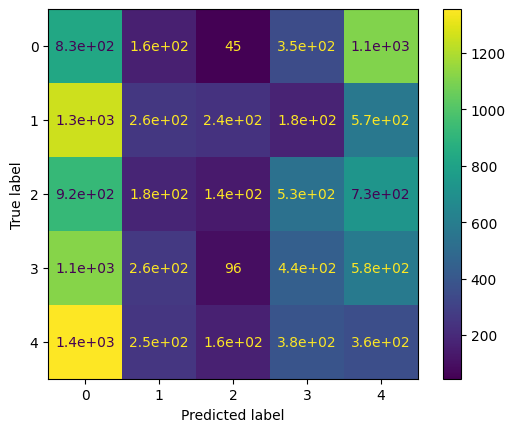

In [75]:
OfflineMetrics.visualize_conf_matrix(OfflineMetrics.get_CONF_MAT(y_true=feature_dic_4['training_labels'], y_predictions=predictions))

In [4]:
emg_regex_filters = [
        data_handler.RegexFilter(left_bound = "C_", right_bound="_R_", values = [str(i) for i in REPS], description='reps'),
        data_handler.RegexFilter(left_bound = "_R_", right_bound="_emg.csv", values = [str(i) for i in CLASSES], description='classes')

    ]

emg_regex_filters

In [ ]:
feature_dic_0 , windows_0 = get_training_data(folder_location="data/S" + str("0") + "/", regex_filters= emg_regex_filters)
feature_dic_1 , windows_1 = get_training_data(folder_location="data/S" + str("1") + "/", regex_filters= emg_regex_filters)
feature_dic_2 , windows_2 = get_training_data(folder_location="data/S" + str("2") + "/", regex_filters= emg_regex_filters)
feature_dic_3 , windows_3 = get_training_data(folder_location="data/S" + str("3") + "/", regex_filters= emg_regex_filters)

print("EMG features 0 : \n", feature_dic_0['training_features']['LS'])
print("EMG features 1 : \n", feature_dic_1['training_features']['LS'])
print("EMG features 2 : \n", feature_dic_2['training_features']['LS'])
print("EMG features 3 : \n", feature_dic_3['training_features']['LS'])
